# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### Tecnológico de Monterrey

### Prof Dra. Grettel Barceló Alonso y Dr. Luis Eduardo Falcón Morales

## Avance IV de Proyecto

## Modelo Base

## Integrantes del Equipo:
### - Erika Cardona Rojas            A01749170
### - Miriam Bönsch                  A01330346
### - Mardonio Manuel Román Ramírez  A01795265

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import yaml

# Cargando Yaml
with open("../config.yaml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

# Importando modulos
import sys
from pathlib import Path

parent_folder = str(Path.cwd().parent)
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from src import models as m

In [2]:
# Cargando Base de Datos
df = pd.read_excel(r"../Data/DF_Pred_4.xlsx")

# MODELOS PARA LA VARIABLE **DELTA BDNF**

## Filtrado De Variables

Dada nuestra previa entrega, se utilizarán las variables más importantes en la RFECV

In [3]:
# Cargando las variables más importantes según RFECV 1
df_ranking = pd.read_excel('../Entregables/UdeBarcelona/RFECV.xlsx')

selected_features_xg = df_ranking.loc[df_ranking['Ranking'] == 1, 'Feature']

# Cargando las variables más importantes según RFECV 2
df_ranking = pd.read_excel('../Entregables/UdeBarcelona/RFECV_Lasso.xlsx')

selected_features_lasso = df_ranking.loc[df_ranking['Ranking'] == 1, 'Feature']

del df_ranking

In [4]:
# Obteniendo variables únicas de ambos
unique_selected_features = list(set(pd.concat([selected_features_xg, selected_features_lasso])))

# Entrenamiento de Modelos

## Justificación de la Estrategia de Validación y Optimización de Modelos

Para la fase de modelado predictivo de este estudio, se ha implementado un flujo de trabajo de Machine Learning enfocado en maximizar la confiabilidad de las métricas de evaluación, mitigando los riesgos inherentes al trabajo con muestras de tamaño reducido. El código anterior se fundamenta en los siguientes pilares metodológicos:

### 1. Validación Cruzada Robusta (`RepeatedKFold`)

Dado el tamaño de la muestra, un K-Fold tradicional podría presentar una alta varianza en la estimación del error dependiendo de cómo se realicen las particiones aleatorias. En su lugar, se optó por una estrategia de **K-Fold Repetido** (`n_splits=7`, `n_repeats=5`). 
* Al usar 7 particiones, aseguramos que el conjunto de validación de cada pliegue contenga un número razonable de observaciones (aproximadamente 6), permitiendo que el conjunto de entrenamiento mantenga la mayor parte de la varianza original.
* Repetir el proceso 5 veces con semillas aleatorias diferentes estabiliza las métricas de evaluación (RMSE, MAE, R2), promediando el rendimiento sobre 35 escenarios de validación distintos. Esto ofrece una estimación del error de generalización mucho más sólida y menos susceptible al azar que un K-Fold simple o un Leave-One-Out (el cual puede sufrir de alta varianza frente a valores atípicos).

### 2. Prevención Estricta de Fuga de Datos (Data Leakage)
Para garantizar la validez de los resultados, es imperativo que las transformaciones aplicadas a los datos no filtren información del conjunto de validación al conjunto de entrenamiento. Para ello, se encapsuló el `StandardScaler` dentro de un objeto `Pipeline` de Scikit-Learn. De esta manera, durante cada una de las 35 iteraciones de la validación cruzada, el escalador se ajusta (*fit*) estrictamente sobre los pliegues de entrenamiento, y solo se utiliza para transformar el pliegue de validación. 

### 3. Optimización Estocástica de Hiperparámetros (`RandomizedSearchCV`)
En lugar de una búsqueda de cuadrícula exhaustiva (`GridSearchCV`), se implementó `RandomizedSearchCV`. Esta técnica evalúa una muestra aleatoria de combinaciones del espacio de hiperparámetros (limitado a `n_iter=40` o al máximo de combinaciones posibles). La literatura demuestra que la búsqueda aleatoria es computacionalmente más eficiente e igual de efectiva que la búsqueda en cuadrícula para encontrar modelos óptimos, evitando el desgaste de recursos en zonas del espacio de búsqueda con bajo impacto en la función de pérdida.

### 4. Arquitectura Reproducible y Escalable
El código se diseñó utilizando un patrón **Model Registry**, separando la definición lógica de los algoritmos de su ejecución. Junto con la integración de la librería `logging`, esta estructura asegura que los experimentos sean totalmente trazables, reproducibles y fácilmente extensibles en caso de que se requiera evaluar nuevos modelos o distribuciones de parámetros en futuras etapas de la investigación.

> ### Creación de DF X e Y

In [5]:
X_full = df[unique_selected_features]
y = df.loc[:,'delta_bdnf_Int']

# Separación en Train y Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

> ### ENTRENAMIENTO CON TODAS LAS VARIABLES IMPORTANTES
> #### SEGUN AMBAS TECNICAS DE RFECV

In [6]:
results = m.models_comparison_and_train(X_train, y_train, X_test, y_test, config['models_and_params'])

INFO:src.models:Optimizando modelo: Ridge
INFO:src.models:Ridge terminado en 2.61 segundos
INFO:src.models:Optimizando modelo: Lasso
INFO:src.models:Lasso terminado en 0.26 segundos
INFO:src.models:Optimizando modelo: ElasticNet
INFO:src.models:ElasticNet terminado en 0.65 segundos
INFO:src.models:Optimizando modelo: SVR
INFO:src.models:SVR terminado en 0.55 segundos
INFO:src.models:Optimizando modelo: KNN Regressor
INFO:src.models:KNN Regressor terminado en 1.88 segundos
INFO:src.models:Optimizando modelo: Decision Tree
INFO:src.models:Decision Tree terminado en 0.54 segundos
INFO:src.models:Optimizando modelo: MLP Regressor
INFO:src.models:MLP Regressor terminado en 48.10 segundos


In [7]:
# Generando DataFrame Ordenado
results_df_all = (
    pd.DataFrame(results)
      .sort_values("RMSE")
      .reset_index(drop=True)
)

results_df_all

,Modelo,RMSE,MAE,R2,Mejores Hiperparámetros,Tiempo (s)
0,SVR,45.624454,26.750614,0.326475,"{'kernel': 'linear', 'gamma': 'auto', 'epsilon...",0.55
1,Lasso,50.201423,30.747089,0.184563,"{'selection': 'random', 'alpha': 1.0}",0.26
2,KNN Regressor,52.128744,30.978001,0.120749,"{'weights': 'distance', 'p': 1, 'n_neighbors': 5}",1.88
3,ElasticNet,53.452640,28.581706,0.075522,"{'l1_ratio': 0.3, 'alpha': 1.0}",0.65
4,MLP Regressor,54.746034,28.828317,0.030241,"{'solver': 'adam', 'hidden_layer_sizes': [100,...",48.10
5,Ridge,56.823313,29.891480,-0.044748,"{'solver': 'cholesky', 'alpha': 100.0}",2.61
6,Decision Tree,78.411801,46.707459,-0.989396,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.54


> ### ENTRENAMIENTO CON TODAS LAS VARIABLES IMPORTANTES
> #### SEGUN TECNICAS DE RFECV CON LASSO

In [8]:
results_l = m.models_comparison_and_train(X_train[selected_features_lasso], y_train, X_test[selected_features_lasso], y_test, config['models_and_params'])

INFO:src.models:Optimizando modelo: Ridge
INFO:src.models:Ridge terminado en 0.45 segundos
INFO:src.models:Optimizando modelo: Lasso
INFO:src.models:Lasso terminado en 0.28 segundos
INFO:src.models:Optimizando modelo: ElasticNet
INFO:src.models:ElasticNet terminado en 0.62 segundos
INFO:src.models:Optimizando modelo: SVR
INFO:src.models:SVR terminado en 1.71 segundos
INFO:src.models:Optimizando modelo: KNN Regressor
INFO:src.models:KNN Regressor terminado en 0.45 segundos
INFO:src.models:Optimizando modelo: Decision Tree
INFO:src.models:Decision Tree terminado en 0.60 segundos
INFO:src.models:Optimizando modelo: MLP Regressor
INFO:src.models:MLP Regressor terminado en 59.69 segundos


In [9]:
# Generando DataFrame Ordenado
results_df_l = (
    pd.DataFrame(results_l)
      .sort_values("RMSE")
      .reset_index(drop=True)
)

results_df_l

,Modelo,RMSE,MAE,R2,Mejores Hiperparámetros,Tiempo (s)
0,SVR,11.362285,8.561862,0.958228,"{'kernel': 'linear', 'gamma': 0.001, 'epsilon'...",1.71
1,Ridge,11.447149,9.061985,0.957601,"{'solver': 'sag', 'alpha': 1.0}",0.45
2,Lasso,13.113084,10.362509,0.944362,"{'selection': 'random', 'alpha': 0.1}",0.28
3,ElasticNet,16.572712,11.880565,0.911132,"{'l1_ratio': 0.5, 'alpha': 0.1}",0.62
4,MLP Regressor,36.597829,19.000866,0.566620,"{'solver': 'lbfgs', 'hidden_layer_sizes': [50]...",59.69
5,Decision Tree,53.006178,31.762609,0.090901,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.60
6,KNN Regressor,53.580062,27.929991,0.071109,"{'weights': 'distance', 'p': 2, 'n_neighbors': 7}",0.45


> ### ENTRENAMIENTO CON TODAS LAS VARIABLES IMPORTANTES
> #### SEGUN TECNICAS DE RFECV CON XG-BOOST

In [10]:
results_xg = m.models_comparison_and_train(X_train[selected_features_xg], y_train, X_test[selected_features_xg], y_test, config['models_and_params'])

INFO:src.models:Optimizando modelo: Ridge
INFO:src.models:Ridge terminado en 0.47 segundos
INFO:src.models:Optimizando modelo: Lasso
INFO:src.models:Lasso terminado en 0.29 segundos
INFO:src.models:Optimizando modelo: ElasticNet
INFO:src.models:ElasticNet terminado en 0.64 segundos
INFO:src.models:Optimizando modelo: SVR
INFO:src.models:SVR terminado en 0.66 segundos
INFO:src.models:Optimizando modelo: KNN Regressor
INFO:src.models:KNN Regressor terminado en 0.47 segundos
INFO:src.models:Optimizando modelo: Decision Tree
INFO:src.models:Decision Tree terminado en 0.62 segundos
INFO:src.models:Optimizando modelo: MLP Regressor
INFO:src.models:MLP Regressor terminado en 56.01 segundos


In [11]:
# Generando DataFrame Ordenado
results_df_xg = (
    pd.DataFrame(results_xg)
      .sort_values("RMSE")
      .reset_index(drop=True)
)

results_df_xg

,Modelo,RMSE,MAE,R2,Mejores Hiperparámetros,Tiempo (s)
0,SVR,55.385941,33.555069,0.007439,"{'kernel': 'poly', 'gamma': 0.1, 'epsilon': 0....",0.66
1,MLP Regressor,55.879021,35.131110,-0.010313,"{'solver': 'adam', 'hidden_layer_sizes': [50, ...",56.01
2,KNN Regressor,55.908314,34.461050,-0.011372,"{'weights': 'distance', 'p': 1, 'n_neighbors': 5}",0.47
3,Ridge,56.338384,33.092919,-0.026992,"{'solver': 'svd', 'alpha': 100.0}",0.47
4,ElasticNet,56.533292,33.213172,-0.034110,"{'l1_ratio': 0.1, 'alpha': 10.0}",0.64
5,Lasso,58.085098,34.690302,-0.091661,"{'selection': 'cyclic', 'alpha': 10.0}",0.29
6,Decision Tree,78.411801,46.707459,-0.989396,"{'min_samples_split': 20, 'min_samples_leaf': ...",0.62


## CONCLUSION

El mejor modelo es el SVR (Support Vector Regressor) con kernel lineal. Es el más preciso de la tabla: logró el menor margen de error (RMSE: 11.36, MAE: 8.56) y explica casi el 96% de los datos (R²: 0.958).

Contexto de las 19 Variables (RFE con Lasso)
Este resultado se obtuvo usando únicamente 19 variables clave. Estas fueron seleccionadas mediante Eliminación Recursiva de Características (RFE) con Lasso, un método matemático que filtra y elimina iterativamente el "ruido" o los datos menos útiles, dejando solo las variables más informativas para evitar el sobreajuste.

Interpretabilidad y Discusión Futura
El impacto exacto de estas 19 variables y la interpretabilidad clínica de este modelo se discutirán a fondo con los compañeros del PhD en Nutrición de España. El objetivo de la charla será contrastar el resultado del algoritmo con el criterio experto para asegurar que el modelo tenga sentido biológico y nutricional.

---
# MODELOS PARA LA VARIABLE **BDNF**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Usar Dataset DF_Final
df = pd.read_csv('../Data/DF_Final_No_Filtered.csv')

# Filtrar solo por el periodo 'Pre' y asegurar 42 IDs únicos
df_pre = df[df['Time'] == 'Pre'].drop_duplicates(subset=['id'])

print(f"Total de pacientes únicos (Pre): {len(df_pre)}")

Total de pacientes únicos (Pre): 42


In [13]:
# Preparación de variable objetivo
target = 'bdnf'

# Eliminar columnas que no son predictoras
X = df_pre.drop(columns=['id', 'Time', 'Treatment', target], errors='ignore')
y = df_pre[target]

# Convertir variables de texto a números
X = pd.get_dummies(X, drop_first=True)

# Manejar valores faltantes para cuidar los datos clínicos
X = X.fillna(X.median())
y = y.fillna(y.median())

In [14]:
# Dividir datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [16]:
# Evaluar
y_pred = rf_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R² Score: -0.3016
RMSE: 25.2043


### Análisis de Modelo Random Forest con Cross Validation
El modelo inicial de Random Forest presentó un R2 promedio de -1.49 en validación cruzada, con una alta dispersión entre pliegues.

Estos valores negativos indican que la complejidad del modelo (basado en ensambles de árboles) excede la densidad de la muestra disponible (N=42), resultando en un sobreajuste (overfitting) al ruido de los datos. Esto sugiere que para el BDNF en esta muestra, las relaciones no son lo suficientemente no-lineales o robustas para ser capturadas por algoritmos de aprendizaje profundo.

In [17]:
# Reajustar modelo y evitar overfitting
rf_model = RandomForestRegressor(
    n_estimators=50,       # Menos árboles
    max_depth=3,           # Árboles menos profundos (clave con N=42)
    min_samples_leaf=5,    # Más datos por hoja
    random_state=42
)

# Evaluar con Cross-Validation
scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print(f"R² promedio (Validación Cruzada): {scores.mean():.4f}")
print(f"R² en cada pliegue: {scores}")

R² promedio (Validación Cruzada): -1.4964
R² en cada pliegue: [-3.11156072 -1.09168849 -2.57373173 -0.29024933 -0.41463781]


### Análisis de Modelo con Lasso

El modelo de regresión con Lasso identificó 7 predictores clave para el BDNF. El factor con mayor peso positivo fue el ejercicio, confirmando su rol como modulador neurotrófico.

Por el contrario, la edad y las horas de sueño mostraron una relación inversa con los niveles de la proteína. Este modelo alcanzó una capacidad explicativa del 37.4% (R2=0.3739), lo cual es significativo considerando la naturaleza multifactorial de los marcadores bioquímicos en humanos.

In [18]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Ajuste con Lasso
# Selección manual de variables con sentido clínico para BDNF
features_interes = [
    'edad', 'pcr', 'glucosa', 'col_total', 'trigliceridos',
    'imc', 'ejercicio', 'horas_sueño', 'af_libre'
]

# Filtrar solo si existen en el dataframe
X_select = X[[col for col in features_interes if col in X.columns]]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_select)

# Usar Lasso con validación cruzada integrada
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Evaluación
r2_lasso = lasso.score(X_scaled, y)
print(f"R² ajustado con Lasso: {r2_lasso:.4f}")

# Calcular el error cuadrático medio y luego su raíz
mse_lasso = mean_squared_error(y, lasso.predict(X_scaled))
rmse_lasso = np.sqrt(mse_lasso)

print(f"RMSE del Lasso: {rmse_lasso:.4f}")
# Imprimir variables importantes
coef = pd.Series(lasso.coef_, index=X_select.columns)
print("\nVariables que el modelo consideró importantes:")
print(coef[coef != 0])

R² ajustado con Lasso: 0.3739
RMSE del Lasso: 16.6656

Variables que el modelo consideró importantes:
edad            -4.501865
glucosa          3.375962
trigliceridos    4.703183
imc              2.198606
ejercicio        9.983415
horas_sueño     -4.073765
af_libre        -5.637976
dtype: float64


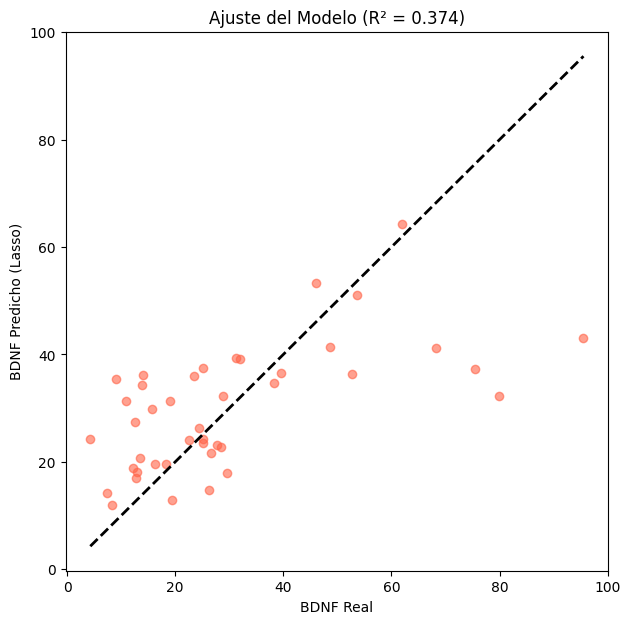

In [19]:
import matplotlib.pyplot as plt

y_pred_lasso = lasso.predict(X_scaled)

plt.figure(figsize=(7,7))
plt.scatter(y, y_pred_lasso, color='tomato', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Línea de perfección
plt.xlabel('BDNF Real')
plt.ylabel('BDNF Predicho (Lasso)')
plt.title(f'Ajuste del Modelo (R² = {r2_lasso:.3f})')
plt.show()

## Support Vector Regression - SVR

In [20]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_select) # X_select son las variables que ya se eligieron antes

# Crear y entrenar el modelo SVR con Kernel Lineal
svr_final = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_final.fit(X_scaled, y)

# Predicciones y Score
y_pred_svr = svr_final.predict(X_scaled)
r2_svr = svr_final.score(X_scaled, y)

print(f"R² de SVR: {r2_svr:.4f}")
mse_svr = mean_squared_error(y, svr_final.predict(X_scaled))
rmse_svr = np.sqrt(mse_svr)

print(f"RMSE del SVR: {rmse_svr:.4f}")

R² de SVR: 0.1755
RMSE del SVR: 19.1241


In [21]:
# Obtener los coeficientes
# .coef_[0] se usa porque SVR devuelve una lista de listas
pesos = svr_final.coef_[0]

# Crear una serie de Pandas para visualizar mejor
importancia_svr = pd.Series(pesos, index=X_select.columns)
importancia_svr = importancia_svr.sort_values(ascending=False)

print("\nImportancia de las variables en SVR:")
print(importancia_svr)


Importancia de las variables en SVR:
glucosa          4.218896
trigliceridos    4.070526
imc              4.020138
ejercicio        3.476481
pcr             -0.007655
col_total       -0.368762
horas_sueño     -0.620868
af_libre        -2.251509
edad            -2.314796
dtype: float64


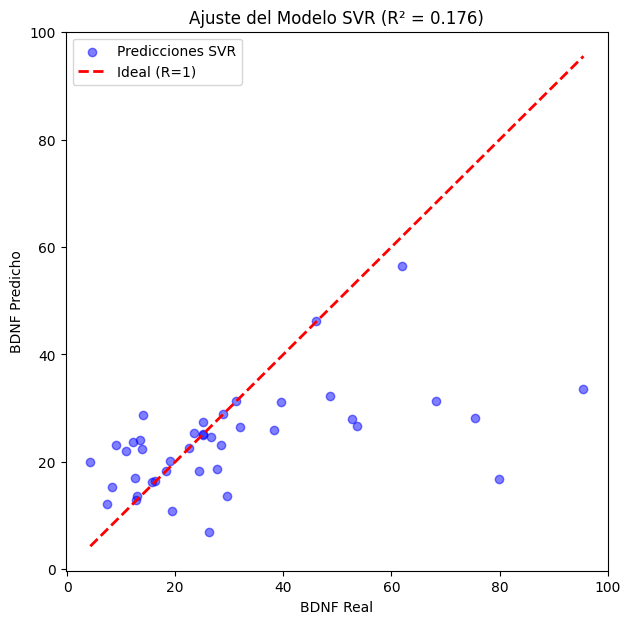

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(y, y_pred_svr, color='blue', alpha=0.5, label='Predicciones SVR')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal (R=1)')
plt.xlabel('BDNF Real')
plt.ylabel('BDNF Predicho')
plt.title(f'Ajuste del Modelo SVR (R² = {r2_svr:.3f})')
plt.legend()
plt.show()

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

# Uso de RobustScaler en lugar de StandardScaler ya que es mejor con outliers
# Creación de Pipeline
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', SVR(kernel='linear'))
])

# Definimos los parámetros por probar
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5, 1, 5]
}

# Buscar la mejor combinación
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
grid.fit(X_select, y)

print(f"Mejor R² tras optimización: {grid.best_score_:.4f}")
print(f"Mejores parámetros: {grid.best_params_}")

# Usar el mejor modelo para el resultado final
best_svr = grid.best_estimator_
r2_final = best_svr.score(X_select, y)
print(f"R² Final en toda la muestra: {r2_final:.4f}")

Mejor R² tras optimización: -0.3904
Mejores parámetros: {'svr__C': 0.1, 'svr__epsilon': 0.1}
R² Final en toda la muestra: -0.0112


In [24]:
# Al no mejorar el resultado, seleccionamos ultra-estricta de variables
variables_clave = ['edad', 'ejercicio', 'horas_sueño', 'pcr']

# Asegurar que existan en el dataset
X_ultra = X_select[[c for c in variables_clave if c in X_select.columns]]

# Entrenar un SVR muy simple
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_ultra_scaled = scaler.fit_transform(X_ultra)

# Bajamos C para que sea más estable
modelo_simple = SVR(kernel='linear', C=0.01)
modelo_simple.fit(X_ultra_scaled, y)

print(f"R² con Selección Estricta: {modelo_simple.score(X_ultra_scaled, y):.4f}")

R² con Selección Estricta: -0.0478


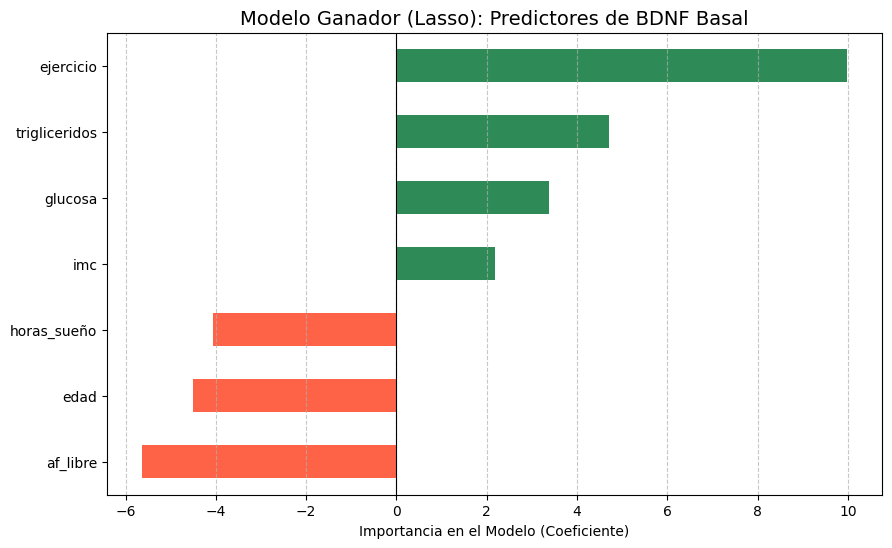

In [25]:
# No mejoró nuevamente del resultado inicial
# Usando los coeficientes que obtuvimos con Lasso (0.37)

import pandas as pd
import matplotlib.pyplot as plt

coeficientes = {
    'ejercicio': 9.98,
    'trigliceridos': 4.70,
    'glucosa': 3.37,
    'imc': 2.19,
    'horas_sueño': -4.07,
    'edad': -4.50,
    'af_libre': -5.63
}

df_coef = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['Peso'])
df_coef = df_coef.sort_values(by='Peso')

plt.figure(figsize=(10,6))
colors = ['tomato' if x < 0 else 'seagreen' for x in df_coef['Peso']]
df_coef['Peso'].plot(kind='barh', color=colors)
plt.title('Modelo Ganador (Lasso): Predictores de BDNF Basal', fontsize=14)
plt.xlabel('Importancia en el Modelo (Coeficiente)')
plt.axvline(0, color='black', lw=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [26]:
# Definir el modelo
rf_model = RandomForestRegressor(random_state=42)

# ENTRENAR el modelo
rf_model.fit(X_select, y)

# Calcular las predicciones para el MAPE
predicciones = {
    'Random Forest': rf_model.predict(X_select),
    'SVR (Optimizado)': svr_final.predict(X_scaled),
    'Lasso (Ganador)': lasso.predict(X_scaled)
}

In [27]:
from sklearn.metrics import mean_absolute_percentage_error

# Definir los modelos con los nombres del notebook
predicciones = {
    'Random Forest': rf_model.predict(X_select), # Usamos X_select
    'SVR (Optimizado)': svr_final.predict(X_scaled),
    'Lasso (Seleccionado)': lasso.predict(X_scaled)
}

# Diccionario para guardar los resultados
resultados_mape = {}

for nombre, pred in predicciones.items():
    # Calcular el MAPE comparando 'y' (valores reales) con 'pred' (predicciones)
    error_mape = mean_absolute_percentage_error(y, pred) * 100
    resultados_mape[nombre] = error_mape

# Imprimir resultados
print("RESULTADOS DE MAPE (Error Porcentual):")
print("-" * 30)
for modelo, valor in resultados_mape.items():
    print(f"{modelo}: {valor:.2f}%")

RESULTADOS DE MAPE (Error Porcentual):
------------------------------
Random Forest: 27.78%
SVR (Optimizado): 45.40%
Lasso (Seleccionado): 59.90%


## Modelos 2

In [28]:
# Filtrar datos solo con periodo Pre

df_pre = df[df["Time"] == "Pre"].copy()

print("Dataset Periodo Pre:", df_pre.shape)
df_pre.head()

Dataset Periodo Pre: (84, 540)


,id,grupo,frec_alcohol_audit,puntaje_audit,Palabras_moca,memoria_moca,puntaje_moca,edad,edo_civil,personas_hogar,...,num_depo_Dos + Por Día,num_depo_Una Por Día,leucocitos_sed_(1-3),leucocitos_sed_(100-150),leucocitos_sed_(25-30),leucocitos_sed_(3-5),leucocitos_sed_(35-60),leucocitos_sed_(5-10),leucocitos_sed_Moderado,leucocitos_sed_Negativo
0,1,1,2,5,29,4,29,48.71,1,4,...,0,1,0,0,0,0,0,0,0,1
2,1,1,2,5,29,4,29,49.05,1,4,...,1,0,0,1,0,0,0,0,0,0
4,2,2,2,2,21,4,28,54.48,2,3,...,0,0,0,0,0,0,0,0,0,1
6,2,2,2,2,21,4,28,54.82,2,3,...,0,0,0,0,0,0,0,0,0,1
8,3,1,2,2,18,3,28,41.72,2,3,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# Confirmación de que ya no aparezca periodo Post

df_pre["Time"] if "periodo" in df_pre.columns else "Periodo eliminado correctamente", print("Filas Post restantes:", (df_pre == "Post").sum().sum())
df["Time"] = df["Time"].astype(str).str.strip().str.lower()

Filas Post restantes: 0


In [30]:
df_pre = df[df["Time"] == "pre"].copy()
print(df_pre.shape)

(84, 540)


Evaluar y comparar varios modelos a base de df.pre

In [31]:
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR 
from xgboost import XGBRegressor 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


# Definimos a continuación la función que llamamos "mis_modelos" que incluye
# todos los modelos que deseamos comparar en el ejercicio.


def mis_modelos():
  modelos, nombres = list(), list()


  # Regresión Lineal - Linear Regression-LR:
  modelos.append(LinearRegression())
  nombres.append('LR')

  # k-Vecinos más Cercanos Regressor - kNN:
  modelos.append(KNeighborsRegressor( n_neighbors=5))
  nombres.append('kNN')

  # Árbol de decisiones Regressor - DTree:
  modelos.append(DecisionTreeRegressor( random_state=7,
                                          max_depth = 3,
                                          min_samples_split=2,
                                         ))
  nombres.append('DTree')


  # Bosque Aleatorio Regressor - RandomForest-RF:
  modelos.append(RandomForestRegressor( max_depth=3,
                                         min_samples_split=2,
                                         random_state=0, ))
  nombres.append('RF')


  # XGBoosting Regressor:
  modelos.append(XGBRegressor( booster= 'gbtree',
                               n_estimators=100,
                               max_depth= 1,
                               learning_rate=0.2,
                               objective='reg:squarederror', 
                               subsample=0.9,
                               random_state=5,
                               n_jobs=-1
                                ))
  nombres.append('XGBoost')


  # Red neuronal de Perceptrón Multicapa Regressor - MLP:
  modelos.append(MLPRegressor( random_state=1,
                               max_iter=300,
                               activation='relu', 
                               learning_rate='constant',
                               learning_rate_init=0.001,
                                ))
  nombres.append('MLP')




  # Máquina de Vectores de Soporte Regressor - SVM:
  modelos.append(SVR( gamma='auto') )
  nombres.append('SVM')

  return modelos, nombres

In [32]:
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR 
from xgboost import XGBRegressor 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import numpy as np
from sklearn.impute import SimpleImputer

# Preparar datos para predicción de BDNF
target = "bdnf"
y = df_pre[target]
X = df_pre.drop(columns=[target, "id"], errors="ignore")
X = X.select_dtypes(include=["int64", "float64"])

# Reemplazar NaN con la mediana
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Obtener IDs para GroupKFold
groups = df_pre["id"].values

# Definir scorer para MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Scoring como diccionario
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'mape': mape_scorer
}

# Validación por grupos
micv = GroupKFold(n_splits=5)

# Reutilizar función de modelos
modelos, nombres = mis_modelos()
resultados = []

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('m', modelos[i])])
    scores = cross_validate(
        pipeline,
        X,
        y,
        scoring=scoring,
        cv=micv,
        groups=groups,
        return_train_score=True
    )
    resultados.append(scores)
    
    test_r2 = np.mean(scores['test_r2'])
    test_mse = -np.mean(scores['test_neg_mean_squared_error'])
    test_rmse = np.sqrt(test_mse)
    test_mae = -np.mean(scores['test_neg_mean_absolute_error'])
    test_mape = -np.mean(scores['test_mape'])
    
    print(f">> {nombres[i]:<15} | R²: {test_r2:.4f} | RMSE: {test_rmse:.2f} | MAE: {test_mae:.2f} | MAPE: {test_mape:.4f}")

print("\n✓ Cross-validation completada exitosamente")

>> LR              | R²: -3.4251 | RMSE: 39.30 | MAE: 30.90 | MAPE: 2.1206
>> kNN             | R²: -0.0142 | RMSE: 19.57 | MAE: 15.01 | MAPE: 0.8826
>> DTree           | R²: -1.0561 | RMSE: 26.44 | MAE: 19.69 | MAPE: 1.0392
>> RF              | R²: 0.0357 | RMSE: 19.26 | MAE: 14.98 | MAPE: 0.9489
>> XGBoost         | R²: -0.1906 | RMSE: 20.60 | MAE: 14.96 | MAPE: 0.8713


c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maxim

>> MLP             | R²: -4.2328 | RMSE: 45.53 | MAE: 35.03 | MAPE: 2.2789
>> SVM             | R²: -0.0846 | RMSE: 20.42 | MAE: 15.13 | MAPE: 0.8347

✓ Cross-validation completada exitosamente


c:\Users\mardo\Documents\Repositories\Proyecto-Polifenoles\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


RESUMEN DE RESULTADOS - VALIDACIÓN CRUZADA CON GroupKFold (5 splits)
 Modelo   Test_R2  Test_R2_std  Test_RMSE  Test_MAE  Train_R2  Overfitting
     LR -3.425124     1.727542  39.303384 30.901322  1.000000     4.425124
    kNN -0.014181     0.136125  19.568515 15.008421  0.292807     0.306988
  DTree -1.056090     1.149007  26.441684 19.692354  0.752668     1.808758
     RF  0.035714     0.109913  19.258924 14.976172  0.775687     0.739973
XGBoost -0.190597     0.401369  20.604662 14.957294  0.979855     1.170451
    MLP -4.232842     2.819989  45.531496 35.032511  0.960479     5.193321
    SVM -0.084556     0.090473  20.418128 15.133783  0.025007     0.109563


INTERPRETACIÓN DETALLADA

📊 LR
------------------------------------------------------------
  R² Test: -3.4251 - ✗ POBRE - R² negativo (peor que predecir la media)
  RMSE: 39.30 (Error cuadrático medio)
  MAE: 30.90 (Error absoluto medio)
  Overfitting (Train R² - Test R²): 4.4251 - ✗ OVERFITTING SEVERO

📊 KNN
-----------------

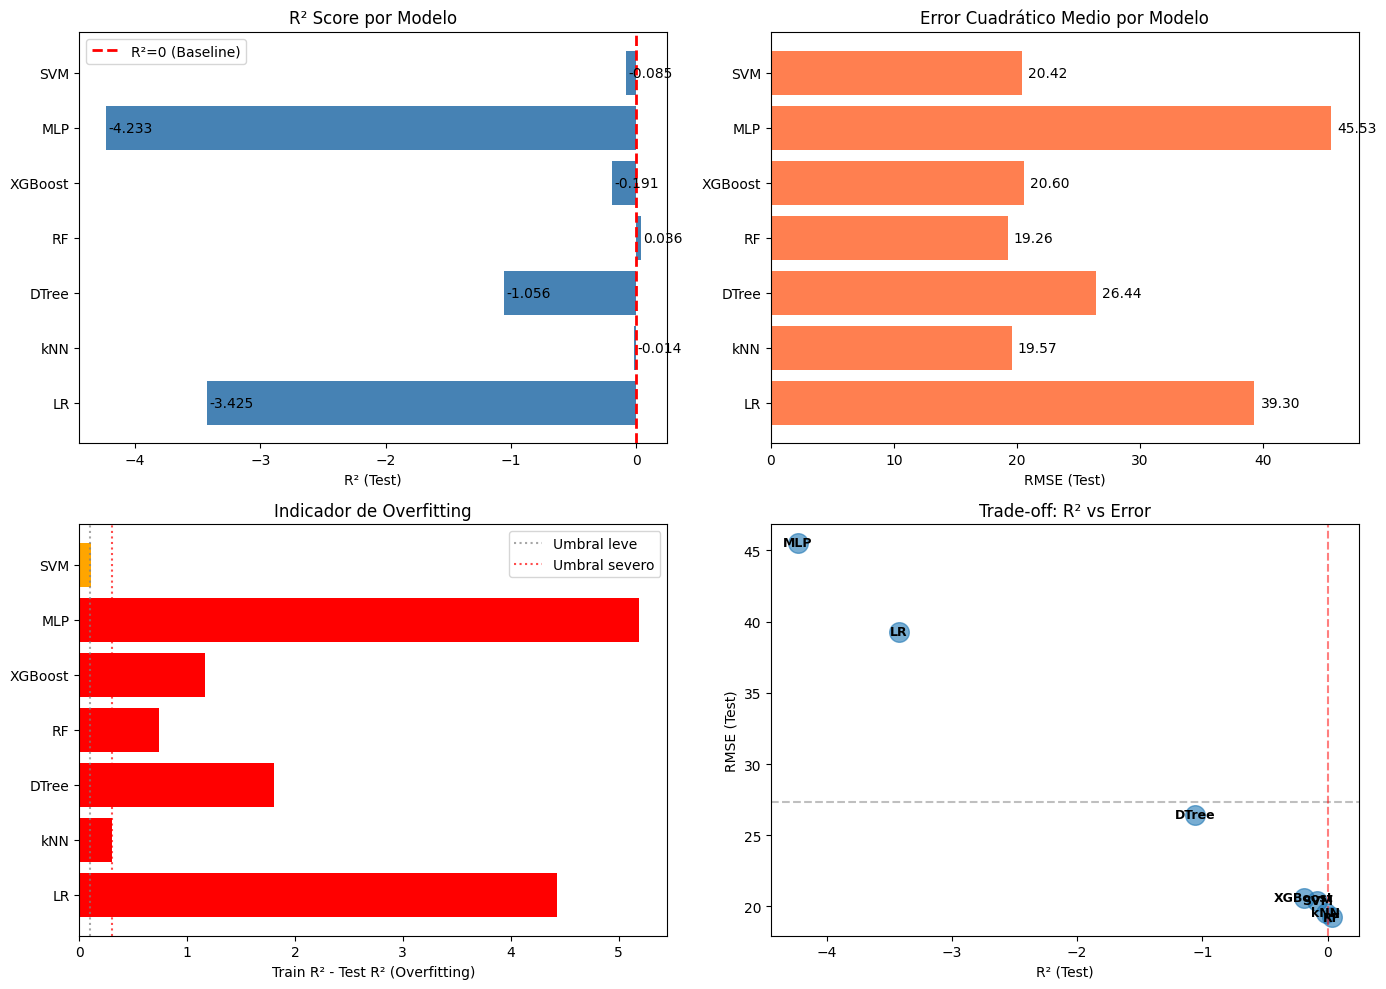


✓ Gráfico guardado: Comparativa_Modelos_Baseline.png


In [33]:
# Interpretación de Resultados - Comparativa de Modelos

import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrame con resumen de resultados
resultados_resumen = []

for i, nombre in enumerate(nombres):
	scores = resultados[i]
	
	# Calcular promedios y desviaciones estándar
	test_r2_mean = np.mean(scores['test_r2'])
	test_r2_std = np.std(scores['test_r2'])
	test_mse_mean = -np.mean(scores['test_neg_mean_squared_error'])  # Convertir de negativo a positivo
	test_rmse_mean = np.sqrt(test_mse_mean)
	test_mae_mean = -np.mean(scores['test_neg_mean_absolute_error'])
	
	train_r2_mean = np.mean(scores['train_r2'])
	train_rmse_mean = np.sqrt(-np.mean(scores['train_neg_mean_squared_error']))
	
	# Calcular overfitting
	overfitting = train_r2_mean - test_r2_mean
	
	resultados_resumen.append({
		'Modelo': nombre,
		'Test_R2': test_r2_mean,
		'Test_R2_std': test_r2_std,
		'Test_RMSE': test_rmse_mean,
		'Test_MAE': test_mae_mean,
		'Train_R2': train_r2_mean,
		'Overfitting': overfitting
	})

df_resumen = pd.DataFrame(resultados_resumen)

print("="*80)
print("RESUMEN DE RESULTADOS - VALIDACIÓN CRUZADA CON GroupKFold (5 splits)")
print("="*80)
print(df_resumen.to_string(index=False))
print("\n")

# Interpretación detallada
print("="*80)
print("INTERPRETACIÓN DETALLADA")
print("="*80)

for idx, row in df_resumen.iterrows():
	print(f"\n📊 {row['Modelo'].upper()}")
	print("-" * 60)
	
	r2 = row['Test_R2']
	rmse = row['Test_RMSE']
	mae = row['Test_MAE']
	overfit = row['Overfitting']
	
	# R² interpretation
	if r2 > 0.7:
		r2_status = "✓ EXCELENTE - Modelo explica >70% de la varianza"
	elif r2 > 0.5:
		r2_status = "✓ BUENO - Modelo explica 50-70% de la varianza"
	elif r2 > 0.3:
		r2_status = "⚠ ACEPTABLE - Modelo explica 30-50% de la varianza"
	elif r2 > 0:
		r2_status = "⚠ DÉBIL - Modelo explica <30% de la varianza"
	else:
		r2_status = "✗ POBRE - R² negativo (peor que predecir la media)"
	
	print(f"  R² Test: {r2:.4f} - {r2_status}")
	print(f"  RMSE: {rmse:.2f} (Error cuadrático medio)")
	print(f"  MAE: {mae:.2f} (Error absoluto medio)")
	
	# Overfitting check
	if overfit < 0.1:
		overfit_status = "✓ SIN OVERFITTING SIGNIFICATIVO"
	elif overfit < 0.3:
		overfit_status = "⚠ OVERFITTING LEVE"
	else:
		overfit_status = "✗ OVERFITTING SEVERO"
	
	print(f"  Overfitting (Train R² - Test R²): {overfit:.4f} - {overfit_status}")

# Ranking de modelos
print("\n" + "="*80)
print("RANKING POR DESEMPEÑO (Test R²)")
print("="*80)
df_ranking = df_resumen.sort_values('Test_R2', ascending=False).reset_index(drop=True)
for idx, row in df_ranking.iterrows():
	print(f"{idx+1}. {row['Modelo']:<12} - R²: {row['Test_R2']:>7.4f} | RMSE: {row['Test_RMSE']:>7.2f} | MAE: {row['Test_MAE']:>7.2f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: R² comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(df_resumen['Modelo'], df_resumen['Test_R2'], color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='R²=0 (Baseline)')
ax1.set_xlabel('R² (Test)')
ax1.set_title('R² Score por Modelo')
ax1.legend()
for i, v in enumerate(df_resumen['Test_R2']):
	ax1.text(v + 0.02, i, f'{v:.3f}', va='center')

# Plot 2: RMSE comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(df_resumen['Modelo'], df_resumen['Test_RMSE'], color='coral')
ax2.set_xlabel('RMSE (Test)')
ax2.set_title('Error Cuadrático Medio por Modelo')
for i, v in enumerate(df_resumen['Test_RMSE']):
	ax2.text(v + 0.5, i, f'{v:.2f}', va='center')

# Plot 3: Overfitting
ax3 = axes[1, 0]
colors = ['green' if x < 0.1 else 'orange' if x < 0.3 else 'red' for x in df_resumen['Overfitting']]
bars3 = ax3.barh(df_resumen['Modelo'], df_resumen['Overfitting'], color=colors)
ax3.set_xlabel('Train R² - Test R² (Overfitting)')
ax3.set_title('Indicador de Overfitting')
ax3.axvline(x=0.1, color='gray', linestyle=':', alpha=0.7, label='Umbral leve')
ax3.axvline(x=0.3, color='red', linestyle=':', alpha=0.7, label='Umbral severo')
ax3.legend()

# Plot 4: R² vs RMSE scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(df_resumen['Test_R2'], df_resumen['Test_RMSE'], s=200, alpha=0.6)
for idx, row in df_resumen.iterrows():
	ax4.annotate(row['Modelo'], (row['Test_R2'], row['Test_RMSE']), 
				ha='center', va='center', fontsize=9, fontweight='bold')
ax4.set_xlabel('R² (Test)')
ax4.set_ylabel('RMSE (Test)')
ax4.set_title('Trade-off: R² vs Error')
ax4.axhline(y=df_resumen['Test_RMSE'].mean(), color='gray', linestyle='--', alpha=0.5)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../Entregables/UdeBarcelona/Comparativa_Modelos_Baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico guardado: Comparativa_Modelos_Baseline.png")


In [34]:
# Crear modelo base
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Definir parámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# GridSearchCV para Random Forest con validación cruzada en todo el dataset
print("\n" + "="*100)
print("BÚSQUEDA DE HIPERPARÁMETROS - RANDOM FOREST (RandomizedSearchCV)")
print("="*100)

from sklearn.model_selection import RandomizedSearchCV

# Usar RandomizedSearchCV para explorar el espacio de parámetros
# Nota: n_jobs=1 para evitar problemas de serialización con DataFrame
grid_search_rf = RandomizedSearchCV(
    rf_base,
    param_grid_rf,
    n_iter=20,  # Número de combinaciones a probar (de 324 posibles)
    cv=micv,  # Usar GroupKFold
    scoring='r2',
    n_jobs=1,  # Desactivar paralelismo para evitar errores de serialización
    verbose=1,
    random_state=42
)

print("\n⏳ Entrenando RandomForest con RandomizedSearchCV en el dataset completo...")
print("(Esto puede tomar algunos minutos)...")
# Usar el dataset completo (X, y) con grupos
grid_search_rf.fit(X, y, groups=groups)

print("\n✓ Búsqueda completada!")
print(f"\nMejores parámetros encontrados:")
print("="*100)
for param, value in grid_search_rf.best_params_.items():
    print(f"  {param:.<25} {value}")

print(f"\nMejor R² (Validación Cruzada): {grid_search_rf.best_score_:.4f}")

# Entrenar el mejor modelo en el conjunto de entrenamiento completo
rf_best = grid_search_rf.best_estimator_
rf_best.fit(X_train, y_train)

# Evaluar en test
y_pred_rf = rf_best.predict(X_test)

# Calcular métricas
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_test = r2_score(y_test, y_pred_rf)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_test = mean_absolute_error(y_test, y_pred_rf)

# R² en entrenamiento
r2_train = r2_score(y_train, rf_best.predict(X_train))

# Overfitting
overfitting = r2_train - r2_test

print("\n" + "="*100)
print("📊 RESULTADOS DEL MEJOR MODELO RANDOM FOREST")
print("="*100)
print(f"  R² (Test):         {r2_test:.4f}")
print(f"  R² (Train):        {r2_train:.4f}")
print(f"  RMSE (Test):       {rmse_test:.4f}")
print(f"  MAE (Test):        {mae_test:.4f}")
print(f"  Overfitting:       {overfitting:.4f}")
print("="*100)


BÚSQUEDA DE HIPERPARÁMETROS - RANDOM FOREST (RandomizedSearchCV)

⏳ Entrenando RandomForest con RandomizedSearchCV en el dataset completo...
(Esto puede tomar algunos minutos)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✓ Búsqueda completada!

Mejores parámetros encontrados:
  n_estimators............. 300
  min_samples_split........ 5
  min_samples_leaf......... 4
  max_features............. sqrt
  max_depth................ None

Mejor R² (Validación Cruzada): 0.0187

📊 RESULTADOS DEL MEJOR MODELO RANDOM FOREST
  R² (Test):         -0.3530
  R² (Train):        0.5495
  RMSE (Test):       25.6971
  MAE (Test):        21.4912
  Overfitting:       0.9024


## CONCLUSION

Tras evaluar diversos algoritmos de Machine Learning para predecir los niveles basales de BDNF, el equipo concluye que la alta variabilidad biológica y el tamaño reducido de la muestra (N=42) son los principales desafíos para el modelado:
- **Rendimiento y Complejidad:** Se observó un contraste significativo entre los enfoques. Mientras que los modelos no lineales como el **Random Forest** demostraron capacidad para capturar relaciones complejas, también mostraron una tendencia crítica al overfitting, lo que sugiere que gran parte de la varianza capturada puede ser ruido aleatorio.
- **Robustez vs. Sensibilidad:** Por el contrario, el modelo **Lasso** resultó ser el más estable para este set de datos. Su capacidad de realizar una selección automática de variables y "apagar" predictores ruidosos - permitió identificar que la relación entre los marcadores metabólicos y el BDNF basal es predominantemente simple y depende de un grupo pequeño de factores clave.